<font size=6>Développer une preuve de concept</font>  
<font size=5>Alternative : améliorer la classification grâce à la détection d'objets</font>  
Comme l'approche testée initialement n'a pas fonctionné, j'ai souhaité tester rapidement une autre voie pour améliorer la prédiction des races de chien. J'applique une détection d'objets pour détecter le chien sur la photo et faire un zoom sur la seule partie de l'image où est le chien. Je n'applique pas de zoom si aucun chien n'est détecté.



---

**Vérification de l'environnement**

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE : to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML07"
# IMAGES_DRIVE : to save to cropped images
IMAGES_DRIVE = "/content/drive/My Drive/MachineLearning/ML07/CropImages"

In [2]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [3]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Mounted at /content/drive


---

<font size=5>**Sommaire**</font>

[1. Chargement des données](#1_0)  
[2. Transfer learning : entraînement de la couche de classification](#2_0)  
[3. Fine-tuning de la dernière couche](#3_0)  
[4. Performance de généralisation sur les données de test](#4_0)  
[5. Analyse des résultats](#5_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.1. Analyse de l'accuracy par race de chien](#5_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[5.2. Evolution de l'accuracy en fonction du seuil de probabilité minimale](#5_2)  

---
## <font color=blue>Notebook set-up</font>

**Importation des librairies**

In [4]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import re
import datetime
import random as python_random

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import per_image_standardization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, VGG16, InceptionV3, ResNet50V2
from tensorflow.keras.applications import DenseNet201, EfficientNetB4
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnetv2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import load_model

In [7]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    os.chdir(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Notebook set-up**

In [8]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

In [9]:
RANDOM_SEED = 42
BATCH_SIZE = 32

In [10]:
def reset_random_seeds():
    np.random.seed(RANDOM_SEED)
    python_random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

In [11]:
reset_random_seeds()

**Fonctions personnelles**

In [12]:
def graph_analysis_both(graph_title, history, figsize=(12, 8),
                        only_accuracy=False, is_csv=False):
    if not is_csv:
        train_acc = history.history["accuracy"]
        valid_acc = history.history["val_accuracy"]
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
    else:
        train_acc = history["accuracy"]
        valid_acc = history["val_accuracy"]
        train_loss = history["loss"]
        valid_loss = history["val_loss"]
    epoch_max = len(train_acc)
    epochs_range = np.arange(epoch_max)

    if only_accuracy:
        graph = sfg.MyGraph(graph_title, figsize=figsize)
    else:
        graph = sfg.MyGraph(graph_title, nblin=1, nbcol=2, figsize=figsize)
    graph.add_plot(epochs_range+0.5, train_acc, label="Training Accuracy",
                  multi_index=1)
    graph.add_plot(epochs_range+1, valid_acc, label="Validation Accuracy",
                  subtitle="Accuracy", legend=True, 
                  with_grid="both", grid_style=":", multi_index=1)
    graph.set_axe_x(label="Epoques", tick_min=1, tick_max=epoch_max, multi_index=1)
    graph.set_axe_y(tick_labels_format=":.2%", multi_index=1)
    ymin, ymax = graph.ax[0].get_ylim()
    idx_ref = np.argmax(valid_acc)
    graph.add_fleches(idx_ref+1, ymax, 0, valid_acc[idx_ref]-ymax,
                      units='xy', color="dimgrey", multi_index=1)
    if not only_accuracy:
        graph.add_plot(epochs_range+0.5, train_loss, label="Training Loss",
                      multi_index=2)
        graph.add_plot(epochs_range+1, valid_loss, label="Validation Loss",
                      subtitle="Perte (categorical cross entropy)", legend=True,
                      with_grid="both", grid_style=":", multi_index=2)
        graph.set_axe_x(label="Epoques", label_position=(1.1, 0.5),
                        tick_min=1, tick_max=epoch_max, multi_index=1)
        graph.set_axe_x(tick_min=1, tick_max=epoch_max, multi_index=2)
        graph.set_axe_y(tick_min=0, tick_max=10, multi_index=2)
        ymin, ymax = graph.ax[1].get_ylim()
        idx_ref = np.argmin(valid_loss)
        graph.add_fleches(idx_ref+1, ymax, 0, valid_loss[idx_ref]-ymax,
                          units='xy', color="dimgrey", multi_index=2)
    return graph.fig, graph.ax

---
<a id='1_0'></a>

## <font color=blue>1. Chargement des données</font>

Je charge les mêmes données et applique le même traitement aux labels que dans le premier notebook.

In [13]:
tf.__version__

'2.4.0'

In [14]:
tf.keras.__version__

'2.4.0'

In [15]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
#if IN_COLAB:
#    !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [17]:
#if IN_COLAB:
#    !tar -xvf images.tar

I set the image size to 512x512, unlike in other notebooks of this projetc. This is due to the use of an object detection based on 512x512 images. The image size is brought back to 256x256 when cropping on the detected box.

In [18]:
image_size = (256, 256)
data_fulltrain = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_DRIVE,
    label_mode="int", color_mode="rgb",
    image_size=image_size, batch_size=BATCH_SIZE,
    shuffle=True, seed=RANDOM_SEED, validation_split=0.2, subset="training"
)
data_test = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGES_DRIVE,
    label_mode="int", color_mode="rgb",
    image_size=image_size, batch_size=BATCH_SIZE,
    shuffle=True, seed=RANDOM_SEED, validation_split=0.2, subset="validation"
)

Found 22674 files belonging to 120 classes.
Using 18140 files for training.
Found 22674 files belonging to 120 classes.
Using 4534 files for validation.


In [19]:
data_fulltrain

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [20]:
print(data_fulltrain.cardinality().numpy())

567


In [21]:
nb_batches = data_fulltrain.cardinality().numpy()
data_valid = data_fulltrain.take(nb_batches // 5)
data_train = data_fulltrain.skip(nb_batches // 5)

In [22]:
percent_data = 0.1
data_mini = data_train.take(int(np.ceil(percent_data * data_train.cardinality().numpy())))
print(data_mini.cardinality().numpy())

46


**Nettoyage du nom des races de chien**

In [23]:
dog_race = []
short_dog_race = []
for cn in data_fulltrain.class_names:
    full_name = cn[10:].replace("_", " ").title()
    dog_race.append(full_name)
    short_dog_race.append(full_name[:25])

In [24]:
print(dog_race)
print(short_dog_race)

['Chihuahua', 'Japanese Spaniel', 'Maltese Dog', 'Pekinese', 'Shih-Tzu', 'Blenheim Spaniel', 'Papillon', 'Toy Terrier', 'Rhodesian Ridgeback', 'Afghan Hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black-And-Tan Coonhound', 'Walker Hound', 'English Foxhound', 'Redbone', 'Borzoi', 'Irish Wolfhound', 'Italian Greyhound', 'Whippet', 'Ibizan Hound', 'Norwegian Elkhound', 'Otterhound', 'Saluki', 'Scottish Deerhound', 'Weimaraner', 'Staffordshire Bullterrier', 'American Staffordshire Terrier', 'Bedlington Terrier', 'Border Terrier', 'Kerry Blue Terrier', 'Irish Terrier', 'Norfolk Terrier', 'Norwich Terrier', 'Yorkshire Terrier', 'Wire-Haired Fox Terrier', 'Lakeland Terrier', 'Sealyham Terrier', 'Airedale', 'Cairn', 'Australian Terrier', 'Dandie Dinmont', 'Boston Bull', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Scotch Terrier', 'Tibetan Terrier', 'Silky Terrier', 'Soft-Coated Wheaten Terrier', 'West Highland White Terrier', 'Lhasa', 'Flat-Coated Retriever', 'Cur

In [25]:
np.save("dog_race.npy", dog_race)

---
<a id='2_0'></a>

## <font color=blue>2. Transfer learning : entraînement de la couche de classification</font>

In [26]:
def my_transfer_learning(list_trainable_layers=None, learning_rate=0.001):
    reset_random_seeds()
    base_model = EfficientNetB4(include_top=False,
                                weights="imagenet",
                                input_shape=(256, 256, 3),
                                pooling="avg")
    base_model.trainable = False
    inputs = Input(shape=(256, 256, 3), dtype=tf.float32, name="input_img")
    x = efficientnet_preprocess_input(inputs)
    x = base_model(x, training=False)
    outputs = Dense(120, activation="softmax", name="classifier")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

In [ ]:
MODEL_NAME = "efficientnetb4"
SUB_MODEL = "onlytop"

In [ ]:
model = my_transfer_learning()
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy",
                                      save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max",
                                   patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history1 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
454/454 - 4024s - loss: 1.0738 - accuracy: 0.8127 - val_loss: 0.4390 - val_accuracy: 0.8830
Epoch 2/1000
454/454 - 149s - loss: 0.3517 - accuracy: 0.9057 - val_loss: 0.3923 - val_accuracy: 0.8858
Epoch 3/1000
454/454 - 149s - loss: 0.2627 - accuracy: 0.9286 - val_loss: 0.3932 - val_accuracy: 0.8874
Epoch 4/1000
454/454 - 148s - loss: 0.2036 - accuracy: 0.9451 - val_loss: 0.3891 - val_accuracy: 0.8891
Epoch 5/1000
454/454 - 146s - loss: 0.1601 - accuracy: 0.9581 - val_loss: 0.3873 - val_accuracy: 0.8913
Epoch 6/1000
454/454 - 146s - loss: 0.1315 - accuracy: 0.9662 - val_loss: 0.3924 - val_accuracy: 0.8905
Epoch 7/1000
454/454 - 146s - loss: 0.1070 - accuracy: 0.9742 - val_loss: 0.3909 - val_accuracy: 0.8913
Epoch 8/1000
454/454 - 145s - loss: 0.0857 - accuracy: 0.9822 - val_loss: 0.3973 - val_accuracy: 0.8902
Epoch 9/1000
454/454 - 145s - loss: 0.0732 - accuracy: 0.9849 - val_loss: 0.3953 - val_accuracy: 0.8946
Epoch 10/1000
454/454 - 144s - loss: 0.0607 - accuracy: 0.9883 

Je recharge le dernier checkpoint car l'entraînement n'a pas pu aller à son terme, à cause de la limitation à 12h liée à Google Colab.

In [ ]:
MODEL_NAME = "efficientnetb4"
SUB_MODEL = "onlytop"

In [ ]:
model = my_transfer_learning()
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}2.h5".format(SUB_MODEL),
                                      monitor="val_accuracy",
                                      save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max",
                                   patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
model = tf.keras.models.load_model("model_{}.h5".format(SUB_MODEL))
model.save_weights("weights/onlytop_trained")

In [ ]:
epochs = 1000
history2 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
454/454 - 8594s - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.7296 - val_accuracy: 0.9159
Epoch 2/1000
454/454 - 106s - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.7351 - val_accuracy: 0.9162
Epoch 3/1000
454/454 - 105s - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.7345 - val_accuracy: 0.9162
Epoch 4/1000
454/454 - 105s - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.7335 - val_accuracy: 0.9162
Epoch 5/1000
454/454 - 105s - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.7268 - val_accuracy: 0.9173
Epoch 6/1000
454/454 - 105s - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.7332 - val_accuracy: 0.9154
Epoch 7/1000
454/454 - 105s - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.7316 - val_accuracy: 0.9165
Epoch 8/1000
454/454 - 105s - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.7255 - val_accuracy: 0.9168
Epoch 9/1000
454/454 - 105s - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.7327 - val_accuracy: 0.9162
Epoch 10/1000
454/454 - 105s - loss: 0.0061 - accuracy: 0.9978 

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement. Je sauvegarde également le modèle entraîné et les seules poids.

In [ ]:
history2_csv = pd.DataFrame(history2.history)
history2_csv.to_csv("history_{}2.csv".format(SUB_MODEL))

In [ ]:
history1_csv = pd.read_csv("history_onlytop.csv", index_col=0)
history2_csv = pd.read_csv("history_onlytop2.csv", index_col=0)
history_csv = pd.concat([history1_csv, history2_csv], ignore_index=True)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,1.0738,0.8127,0.4390,0.8830
1,0.3517,0.9057,0.3923,0.8858
2,0.2627,0.9286,0.3932,0.8874
3,0.2036,0.9451,0.3891,0.8891
4,0.1601,0.9581,0.3873,0.8913


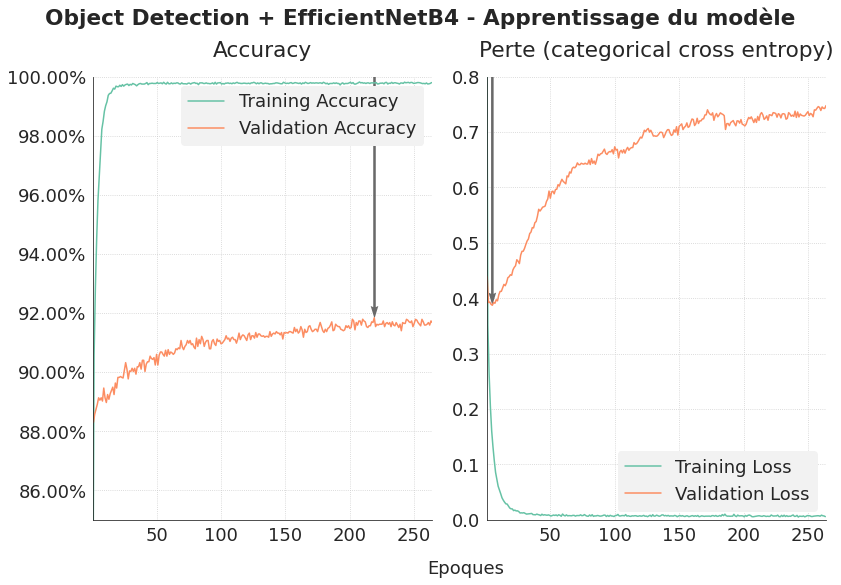

In [ ]:
fig, ax = graph_analysis_both(
    "Object Detection + EfficientNetB4 - Apprentissage du modèle",
    history_csv, is_csv=True)
ax[0].set_ylim([0.85, 1.0])
ax[1].set_ylim([0, 0.8])
plt.show()

---
<a id='3_0'></a>

## <font color=blue>3. Fine-tuning de la dernière couche</font>

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "onelayer"

In [ ]:
model = my_transfer_learning(learning_rate=1e-5)
model.load_weights("weights/onlytop_trained")
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


Je vérifie la performance de validation du modèle, pour m'assurer que le modèle entraîné est bien rechargé.

In [ ]:
model.evaluate(data_valid, return_dict=True)

113/113 [==============================] - 879s 7s/step - loss: 0.9484 - accuracy: 0.9014


{'accuracy': 0.9184181690216064, 'loss': 0.7195520997047424}

L'accuracy de 91,84% correspond à notre modèle entraîné. Je poursuis avec le fine tuning.

In [ ]:
reset_random_seeds()
for layer in model.layers:
    if layer.name == "efficientnetb4":
        layer.trainable = True
        for l in layer.layers[:-4]:
            l.trainable = False


In [ ]:
for layer in model.layers:
    if layer.name == "efficientnetb4":
        for l in layer.layers:
            print("{} : {}".format(l.name, l.trainable))

input_1 : False
rescaling : False
normalization : False
stem_conv_pad : False
stem_conv : False
stem_bn : False
stem_activation : False
block1a_dwconv : False
block1a_bn : False
block1a_activation : False
block1a_se_squeeze : False
block1a_se_reshape : False
block1a_se_reduce : False
block1a_se_expand : False
block1a_se_excite : False
block1a_project_conv : False
block1a_project_bn : False
block1b_dwconv : False
block1b_bn : False
block1b_activation : False
block1b_se_squeeze : False
block1b_se_reshape : False
block1b_se_reduce : False
block1b_se_expand : False
block1b_se_excite : False
block1b_project_conv : False
block1b_project_bn : False
block1b_drop : False
block1b_add : False
block2a_expand_conv : False
block2a_expand_bn : False
block2a_expand_activation : False
block2a_dwconv_pad : False
block2a_dwconv : False
block2a_bn : False
block2a_activation : False
block2a_se_squeeze : False
block2a_se_reshape : False
block2a_se_reduce : False
block2a_se_expand : False
block2a_se_excite :

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 1,021,560
Non-trainable params: 16,867,423
_________________________________________________________________


In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy",
                                      save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max",
                                   patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history3 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
454/454 - 3197s - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.7253 - val_accuracy: 0.9168
Epoch 2/1000
454/454 - 145s - loss: 0.0036 - accuracy: 0.9982 - val_loss: 0.7227 - val_accuracy: 0.9168
Epoch 3/1000
454/454 - 145s - loss: 0.0033 - accuracy: 0.9980 - val_loss: 0.7255 - val_accuracy: 0.9170
Epoch 4/1000
454/454 - 144s - loss: 0.0041 - accuracy: 0.9979 - val_loss: 0.7192 - val_accuracy: 0.9181
Epoch 5/1000
454/454 - 145s - loss: 0.0037 - accuracy: 0.9981 - val_loss: 0.7223 - val_accuracy: 0.9168
Epoch 6/1000
454/454 - 144s - loss: 0.0032 - accuracy: 0.9979 - val_loss: 0.7220 - val_accuracy: 0.9176
Epoch 7/1000
454/454 - 145s - loss: 0.0034 - accuracy: 0.9981 - val_loss: 0.7178 - val_accuracy: 0.9179
Epoch 8/1000
454/454 - 144s - loss: 0.0035 - accuracy: 0.9979 - val_loss: 0.7187 - val_accuracy: 0.9181
Epoch 9/1000
454/454 - 145s - loss: 0.0034 - accuracy: 0.9979 - val_loss: 0.7176 - val_accuracy: 0.9179
Epoch 10/1000
454/454 - 145s - loss: 0.0036 - accuracy: 0.9978 

Ma connection Google Colab a été interrompue avant la fin de l'entraînemet. Je recharge le dernier modèle sauvegardé (validation accuracy de 92,23%) et je reprends l'entraînement.

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "onelayer"

In [ ]:
model = my_transfer_learning(learning_rate=1e-5)
for layer in model.layers:
    if layer.name == "efficientnetb4":
        layer.trainable = True
        for l in layer.layers[:-4]:
            l.trainable = False

71688192/71686520 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
    if layer.name == "efficientnetb4":
        for l in layer.layers:
            print("{} : {}".format(l.name, l.trainable))

input_1 : False
rescaling : False
normalization : False
stem_conv_pad : False
stem_conv : False
stem_bn : False
stem_activation : False
block1a_dwconv : False
block1a_bn : False
block1a_activation : False
block1a_se_squeeze : False
block1a_se_reshape : False
block1a_se_reduce : False
block1a_se_expand : False
block1a_se_excite : False
block1a_project_conv : False
block1a_project_bn : False
block1b_dwconv : False
block1b_bn : False
block1b_activation : False
block1b_se_squeeze : False
block1b_se_reshape : False
block1b_se_reduce : False
block1b_se_expand : False
block1b_se_excite : False
block1b_project_conv : False
block1b_project_bn : False
block1b_drop : False
block1b_add : False
block2a_expand_conv : False
block2a_expand_bn : False
block2a_expand_activation : False
block2a_dwconv_pad : False
block2a_dwconv : False
block2a_bn : False
block2a_activation : False
block2a_se_squeeze : False
block2a_se_reshape : False
block2a_se_reduce : False
block2a_se_expand : False
block2a_se_excite :

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 1,021,560
Non-trainable params: 16,867,423
_________________________________________________________________


In [ ]:
model = tf.keras.models.load_model("model_{}.h5".format(SUB_MODEL))

In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}2.h5".format(SUB_MODEL),
                                      monitor="val_accuracy",
                                      save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max",
                                   patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history4 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
454/454 - 4017s - loss: 0.0047 - accuracy: 0.9977 - val_loss: 0.6979 - val_accuracy: 0.9206
Epoch 2/1000
454/454 - 148s - loss: 0.0035 - accuracy: 0.9978 - val_loss: 0.7000 - val_accuracy: 0.9209
Epoch 3/1000
454/454 - 147s - loss: 0.0032 - accuracy: 0.9979 - val_loss: 0.6999 - val_accuracy: 0.9206
Epoch 4/1000
454/454 - 146s - loss: 0.0033 - accuracy: 0.9979 - val_loss: 0.7024 - val_accuracy: 0.9209
Epoch 5/1000
454/454 - 146s - loss: 0.0029 - accuracy: 0.9980 - val_loss: 0.7021 - val_accuracy: 0.9212
Epoch 6/1000
454/454 - 145s - loss: 0.0039 - accuracy: 0.9978 - val_loss: 0.7010 - val_accuracy: 0.9204
Epoch 7/1000
454/454 - 145s - loss: 0.0029 - accuracy: 0.9981 - val_loss: 0.7017 - val_accuracy: 0.9209
Epoch 8/1000
454/454 - 144s - loss: 0.0026 - accuracy: 0.9982 - val_loss: 0.6990 - val_accuracy: 0.9212
Epoch 9/1000
454/454 - 145s - loss: 0.0037 - accuracy: 0.9979 - val_loss: 0.7016 - val_accuracy: 0.9195
Epoch 10/1000
454/454 - 144s - loss: 0.0032 - accuracy: 0.9979 

In [ ]:
history4_csv = pd.DataFrame(history4.history)
history4_csv.to_csv("history_{}2.csv".format(SUB_MODEL))
# model.save("transferlearning_fitted_onelayer")
# model.save_weights("weights/onelayer_fitted")

In [ ]:
model = tf.keras.models.load_model("model_onelayer2.h5")
model.save_weights("weights/onelayer_fitted")

In [ ]:
history1_csv = pd.read_csv("history_onlytop.csv", index_col=0)
history2_csv = pd.read_csv("history_onelayer.csv", index_col=0)
history3_csv = pd.read_csv("history_onelayer2.csv", index_col=0)
history_csv = pd.concat([history1_csv, history2_csv, history3_csv], ignore_index=True)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,1.0738,0.8127,0.4390,0.8830
1,0.3517,0.9057,0.3923,0.8858
2,0.2627,0.9286,0.3932,0.8874
3,0.2036,0.9451,0.3891,0.8891
4,0.1601,0.9581,0.3873,0.8913


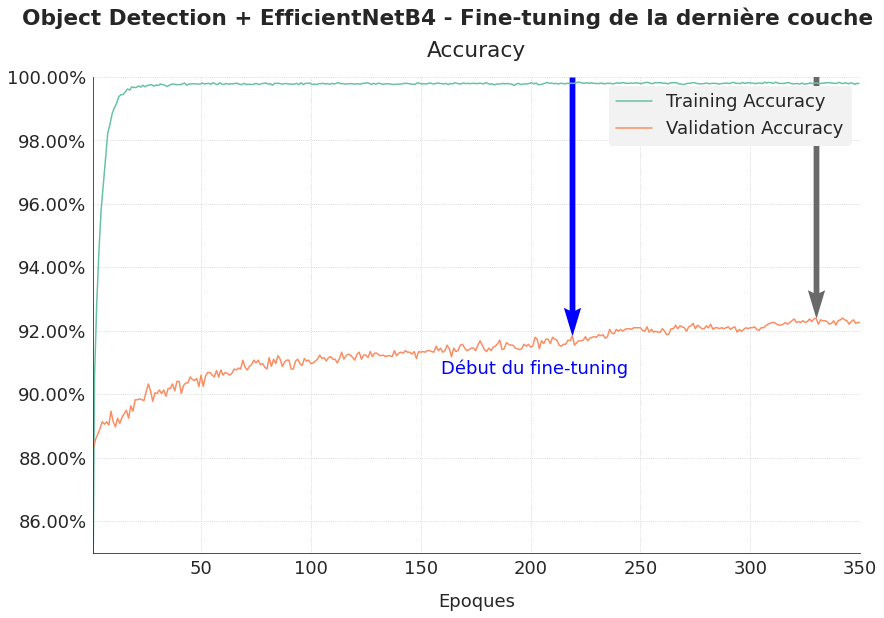

In [ ]:
nb_init = 219
fig, ax = graph_analysis_both(
    "Object Detection + EfficientNetB4 - Fine-tuning de la dernière couche",
    history_csv, is_csv=True, only_accuracy=True)
ax[0].set_ylim([0.85, 1.0])
ymin, ymax = ax[0].get_ylim()
ax[0].quiver(nb_init, ymax, 0, history_csv.iloc[nb_init-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="blue")
ax[0].text(nb_init - 60, history_csv.iloc[nb_init-1].val_accuracy - 0.012,
           "Début du fine-tuning", color="blue")
plt.show()

Le fine-tuning de la dernière couche améliore l'accuracy à 92,39% (contre 91,84% sans fine-tuning) alors que le nombre de paramètres entraînables passe de 215 160 à 1 021 560.  
Il faut voir si cette augmentation du nombre de paramètres n'entraîne pas un overfitting qui pourrait nuire à la généralisation. Pour cela, je compare les performances sur les données de test jamais vues jusqu'ici.

---
<a id='4_0'></a>

## <font color=blue>4. Performance de généralisation sur les données de test</font>

In [ ]:
model = my_transfer_learning()
model.load_weights("weights/onlytop_trained")
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
model.evaluate(data_valid, return_dict=True)

113/113 [==============================] - 864s 7s/step - loss: 0.9484 - accuracy: 0.9014


{'accuracy': 0.9184181690216064, 'loss': 0.7195520997047424}

Je retrouve la performance de validation de 91,84%. C'est le bon modèle qui est rechargé.

In [ ]:
model.evaluate(data_test, return_dict=True)

142/142 [==============================] - 1006s 7s/step - loss: 1.0950 - accuracy: 0.8838


{'accuracy': 0.8837670683860779, 'loss': 1.095034122467041}

La performance de généralisation est légèrement inférieure avec une accuracy de 88.38% sur les données de test. Cela constitue une amélioration par rapport aux 87,80% obtenues sans le crop sur les chiens.

In [ ]:
model2 = my_transfer_learning()
model2.load_weights("weights/onelayer_fitted")
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
model2.evaluate(data_valid, return_dict=True)

113/113 [==============================] - 32s 249ms/step - loss: 0.9697 - accuracy: 0.9006


{'accuracy': 0.9245021939277649, 'loss': 0.6860809326171875}

Je retrouve une performance similaire. C'est le bon modèle qui est rechargé.

In [ ]:
model2.evaluate(data_test, return_dict=True)

142/142 [==============================] - 35s 245ms/step - loss: 1.0842 - accuracy: 0.8858


{'accuracy': 0.8857520818710327, 'loss': 1.084172010421753}

La performance de généralisation est encore (légèrement) supérieure avec une accuracy de 88,58% sur les données de test.  
Ce modèle peut être mis en production.

---
<a id='5_0'></a>

## <font color=blue>5. Analyse des résultats</font>

J'étudie les résultats du modèle adopté : avec le fine-tuning de la dernière couche d'EfficientNetB4. J'étudie sur toutes les données d'entraînement et je vérifie sur les données de test.  
Quelle est l'accuracy par race de chien ?  
Y-a-t'il un seuil de probabilité au-delà duquel la prédiction ne fait jamais d'erreur ?

In [27]:
model = my_transfer_learning()
model.load_weights("weights/onelayer_fitted")
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [28]:
train_targets = None
train_predictions = None
for x, y in data_train:
    if train_targets is None:
        train_targets = y.numpy()
        train_predictions = model.predict(x)
    else:
        train_targets = np.concatenate([train_targets, y.numpy()])
        train_predictions = np.concatenate([train_predictions,
                                            model.predict(x)])

In [29]:
valid_targets = None
valid_predictions = None
for x, y in data_valid:
    if valid_targets is None:
        valid_targets = y.numpy()
        valid_predictions = model.predict(x)
    else:
        valid_targets = np.concatenate([valid_targets, y.numpy()])
        valid_predictions = np.concatenate([valid_predictions,
                                            model.predict(x)])

In [30]:
test_targets = None
test_predictions = None
for x, y in data_test:
    if test_targets is None:
        test_targets = y.numpy()
        test_predictions = model.predict(x)
    else:
        test_targets = np.concatenate([test_targets, y.numpy()])
        test_predictions = np.concatenate([test_predictions,
                                           model.predict(x)])

<a id='5_1'></a>

### 5.1. Analyse de l'accuracy par race de chien

full_targets[idx] = classe à prédire  
np.argmax(full_predictions[idx]) = classe prédite  
-> calcul de l'accuracy par classe (race)

**Données d'entraînement**

In [31]:
pred_by_class = [[] for _dummy in range(len(dog_race))]
accuracy_by_class = []
for idx in range(len(train_targets)):
    pred_by_class[train_targets[idx]].append(np.argmax(train_predictions[idx]))

In [32]:
for cl in range(len(dog_race)):
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(pred_by_class[cl], np.repeat(cl, len(pred_by_class[cl])))
    accuracy_by_class.append(temp_acc.result().numpy())

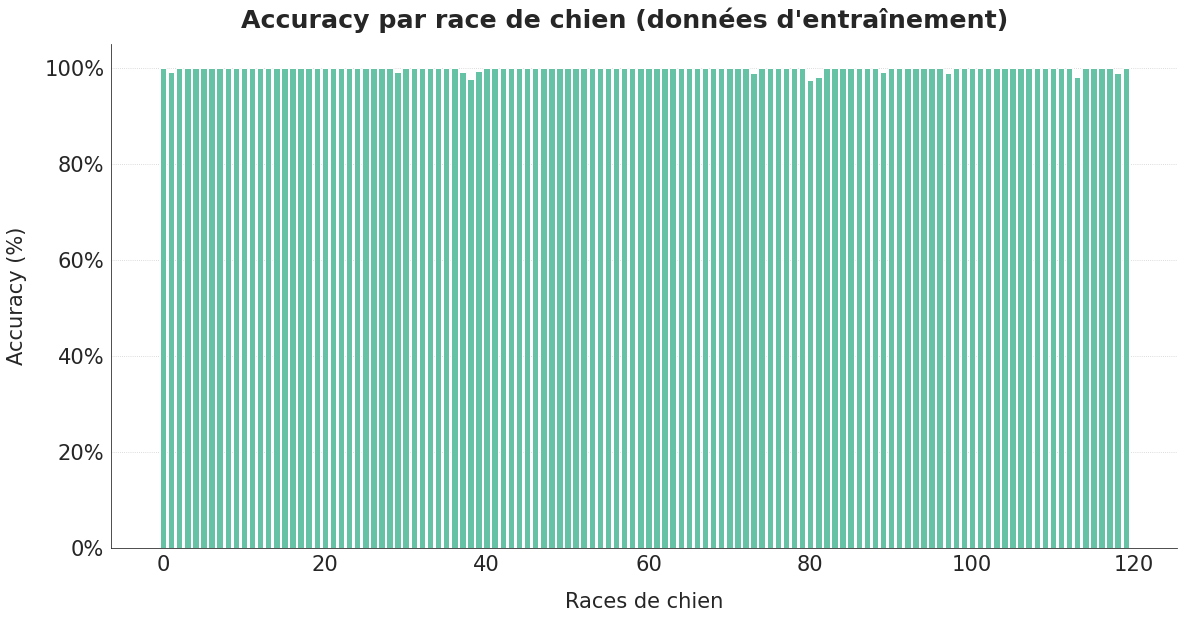

In [33]:
graph = sfg.MyGraph(
    "Accuracy par race de chien (données d'entraînement)",
    figsize=(16, 8))
graph.add_barv(range(len(dog_race)), accuracy_by_class)
graph.set_axe_x(label="Races de chien")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%")
plt.show()

**Données de validation**

In [34]:
pred_by_class = [[] for _dummy in range(len(dog_race))]
accuracy_by_class = []
for idx in range(len(valid_targets)):
    pred_by_class[valid_targets[idx]].append(np.argmax(valid_predictions[idx]))

In [35]:
for cl in range(len(dog_race)):
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(pred_by_class[cl], np.repeat(cl, len(pred_by_class[cl])))
    accuracy_by_class.append(temp_acc.result().numpy())

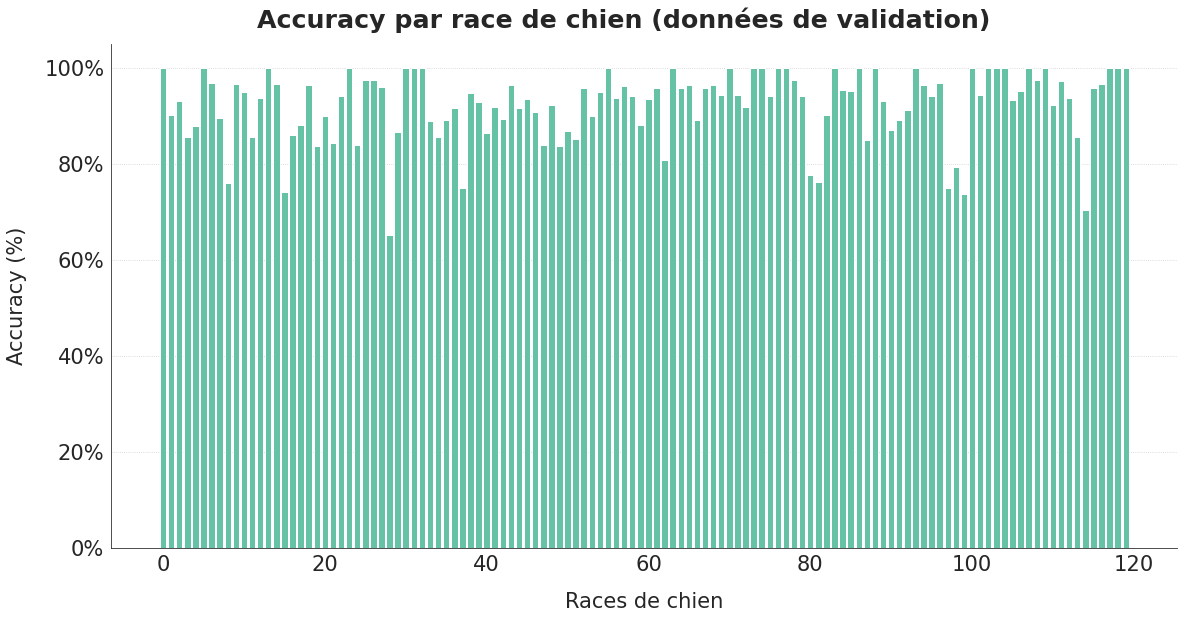

In [36]:
graph = sfg.MyGraph(
    "Accuracy par race de chien (données de validation)",
    figsize=(16, 8))
graph.add_barv(range(len(dog_race)), accuracy_by_class)
graph.set_axe_x(label="Races de chien")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%")
plt.show()

**Données de test**

In [49]:
pred_by_class = [[] for _dummy in range(len(dog_race))]
accuracy_by_class = []
for idx in range(len(test_targets)):
    pred_by_class[test_targets[idx]].append(np.argmax(test_predictions[idx]))

In [50]:
for cl in range(len(dog_race)):
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(pred_by_class[cl], np.repeat(cl, len(pred_by_class[cl])))
    accuracy_by_class.append(temp_acc.result().numpy())

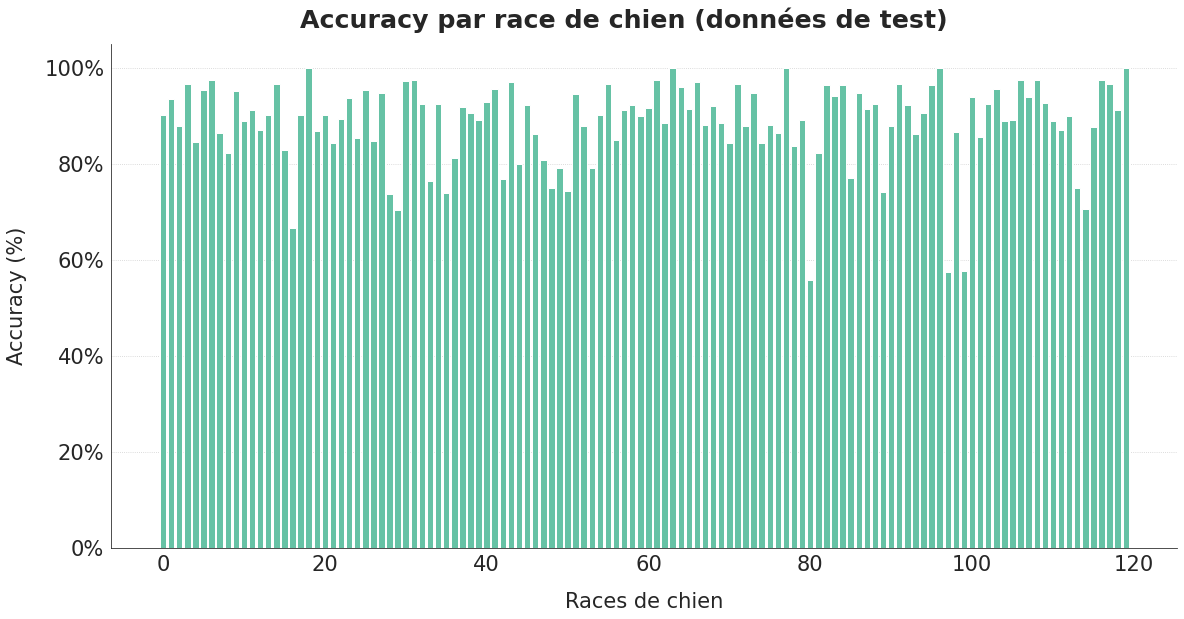

In [51]:
graph = sfg.MyGraph(
    "Accuracy par race de chien (données de test)",
    figsize=(16, 8))
graph.add_barv(range(len(dog_race)), accuracy_by_class)
graph.set_axe_x(label="Races de chien")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%")
plt.show()

**Observations**

Ce sont en général les mêmes races qui ont une moins bonne accuracy sur les données de validation et sur les données de test.  
Je regarde quelles sont les races avec les moins bons résultats, en me basant sur les données de test qui n'ont pas du tout été impliquées dans la détermination du modèle. J'affiche les 24 races avec les moins bonnes accuracy de test, soit les 20% avec les moins bons résultats.

In [53]:
df_acc = pd.DataFrame({"race": dog_race, "accuracy": accuracy_by_class})
df_acc.sort_values(by="accuracy", ascending=True, inplace=True)
df_acc.head(24)

,race,accuracy
80,Collie,0.558824
97,Eskimo Dog,0.575758
99,Siberian Husky,0.577778
16,English Foxhound,0.666667
29,American Staffordshire Terrier,0.703704
114,Miniature Poodle,0.705882
28,Staffordshire Bullterrier,0.736842
35,Norwich Terrier,0.739130
89,Appenzeller,0.740741
50,Silky Terrier,0.742857


Je pourrais pousser plus loin l'analyse en vérifiant si certaines races sont souvent confondues entre elles, afin de dégager des pistes d'amélioration pour ces cas spécifiques.

<a id='5_2'></a>

### 5.2. Evolution de l'accuracy en fonction du seuil de probabilité minimale

Je regarde comment l'accuracy évolue à mesure que la probabilité minimale demandée pour effectuer une classification augmente.

In [40]:
levels = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.91, 0.95, 0.98,
          0.99, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0]

**Données d'entraînement**

In [41]:
accuracy_by_level = []
for level in levels:
    list_pred = []
    list_true = []
    for idx in range(len(train_targets)):
        if max(train_predictions[idx]) >= level:
            list_pred.append(np.argmax(train_predictions[idx]))
            list_true.append(train_targets[idx])
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(list_pred, list_true)
    accuracy_by_level.append(temp_acc.result().numpy())

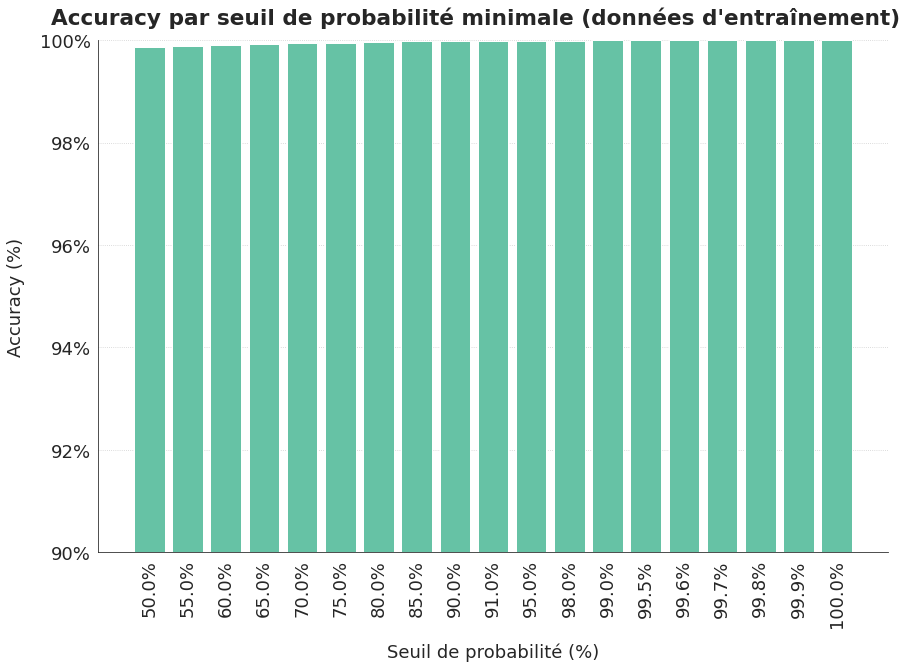

In [42]:
graph = sfg.MyGraph(
    "Accuracy par seuil de probabilité minimale (données d'entraînement)",
    figsize=(12, 8))
graph.add_barv(range(len(levels)), accuracy_by_level)
graph.set_axe_x(label="Seuil de probabilité (%)",
                tick_min=0, tick_max=len(levels)-1, tick_step=1,
                tick_labels=["{:.1%}".format(l) for l in levels],
                rotation=90, ha="center")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%",
                tick_min=0.9, tick_max=1.0)
plt.show()

**Données de validation**

In [43]:
accuracy_by_level = []
for level in levels:
    list_pred = []
    list_true = []
    for idx in range(len(valid_targets)):
        if max(valid_predictions[idx]) >= level:
            list_pred.append(np.argmax(valid_predictions[idx]))
            list_true.append(valid_targets[idx])
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(list_pred, list_true)
    accuracy_by_level.append(temp_acc.result().numpy())

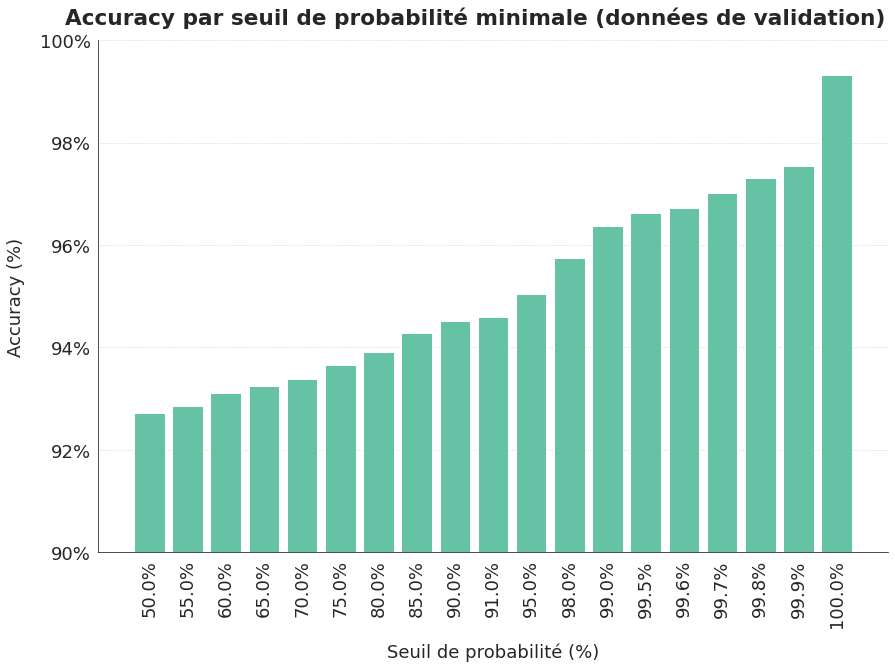

In [44]:
graph = sfg.MyGraph(
    "Accuracy par seuil de probabilité minimale (données de validation)",
    figsize=(12, 8))
graph.add_barv(range(len(levels)), accuracy_by_level)
graph.set_axe_x(label="Seuil de probabilité (%)",
                tick_min=0, tick_max=len(levels)-1, tick_step=1,
                tick_labels=["{:.1%}".format(l) for l in levels],
                rotation=90, ha="center")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%",
                tick_min=0.9, tick_max=1.0)
plt.show()

**Données de test**

In [45]:
accuracy_by_level = []
for level in levels:
    list_pred = []
    list_true = []
    for idx in range(len(test_targets)):
        if max(test_predictions[idx]) >= level:
            list_pred.append(np.argmax(test_predictions[idx]))
            list_true.append(test_targets[idx])
    temp_acc = tf.keras.metrics.Accuracy()
    temp_acc.update_state(list_pred, list_true)
    accuracy_by_level.append(temp_acc.result().numpy())

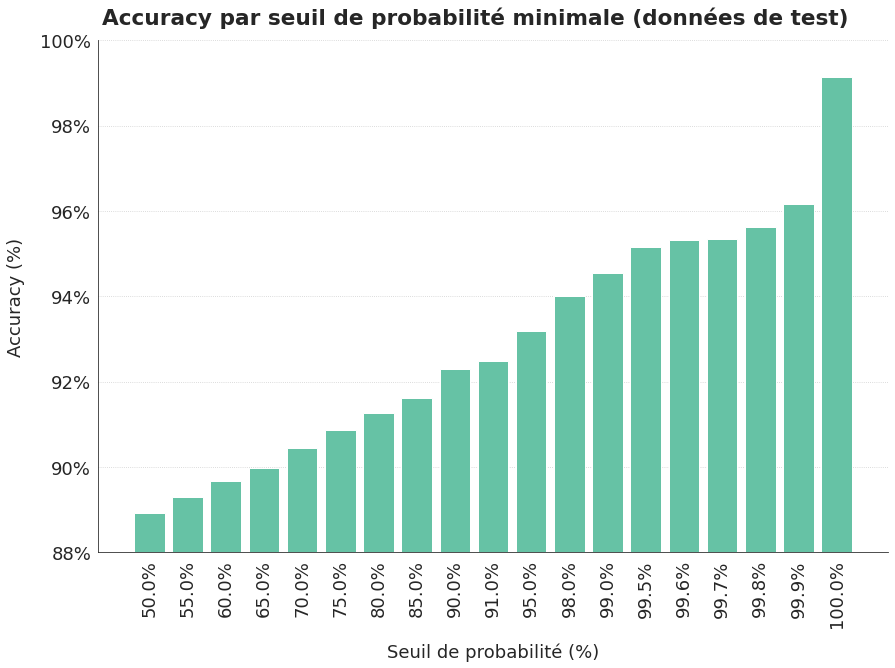

In [48]:
graph = sfg.MyGraph(
    "Accuracy par seuil de probabilité minimale (données de test)",
    figsize=(12, 8))
graph.add_barv(range(len(levels)), accuracy_by_level)
graph.set_axe_x(label="Seuil de probabilité (%)",
                tick_min=0, tick_max=len(levels)-1, tick_step=1,
                tick_labels=["{:.1%}".format(l) for l in levels],
                rotation=90, ha="center")
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%",
                tick_min=0.88, tick_max=1.0)
plt.show()

**Observations**

A partir d'une probabilité de 99.5%, l'accuracy est supérieure à 95%. Il y a une véritable différence de performance entre une probabilité de 99.9% et une probabilité de 100%, avec une accuracy qui passe de 96% à 99% sur les données de test.